### [T5](https://github.com/google-research/text-to-text-transfer-transformer) 
- **Text-To-Text Transfer Transformer**
- A unified framework that converts every language problem into a text-to-text format.
- Achieves state-of-the-art results on many benchmarks covering summarization, question answering, text classification, and more.

### Multi Class vs Multi Label Classification
- **Multi Class** - There are multiple categories but each instance is assigned only one, therefore such problems are known as multi-class classification problem.
- **Multi Label** - There are multiple categories and each instance can be assigned with multiple categories, so these types of problems are known as multi-label classification problem, where we have a set of target labels.

# Imports

The entire code is written using **PyTorch**.<br>
We'll be using the **transformers** library by [huggingface](https://github.com/huggingface/transformers) as they provide wrappers for multiple Transformer models.

In [1]:
# ! pip3 install transformers

In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import re
import copy
from tqdm.notebook import tqdm
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    classification_report
)

from transformers import (
    T5Tokenizer, 
    T5Model,
    T5ForConditionalGeneration,
    get_linear_schedule_with_warmup
)

project_dir = '../input/avjanatahackresearcharticlesmlc/av_janatahack_data/'

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Check the GPU configurations

In [3]:
! nvidia-smi

Mon Aug 24 15:41:47 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Data Preprocessing

We're using just the abstract text, but concatenating the title text along with it performed better on the leaderboard. 
<br><br>

#### Abstracts
- Stripping extra whitespaces around the text.
- Replacing escape characters with whitespace.
- Padding all punctuations with whitespaces on both sides.

#### Labels
- Convert the one hot encoded labels to textual format (since T5 only deals with textual data).<br>
e.g. OHE Labels - [1, 0, 1, 0, 1]<br>T5 Labels - 'computer_science, mathematics, quantitative_finance'

#### Additional Tips
- Replacing Latex equations with a special token.
- Data Augmentation. 



In [4]:
train_df = pd.read_csv(project_dir + 'train.csv')
train_df.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [5]:
# preprocessing
def clean_abstract(text):
    text = text.split()
    text = [x.strip() for x in text]
    text = [x.replace('\n', ' ').replace('\t', ' ') for x in text]
    text = ' '.join(text)
    text = re.sub('([.,!?()])', r' \1 ', text)
    return text
    

def get_texts(df):
    texts = 'multilabel classification: ' + df['ABSTRACT'].apply(clean_abstract)
    texts = texts.values.tolist()
    return texts


def get_labels(df):
    labels_li = [' '.join(x.lower().split()) for x in df.columns.to_list()[3:]]
    labels_matrix = np.array([labels_li] * len(df))

    mask = df.iloc[:, 3:].values.astype(bool)
    labels = []
    for l, m in zip(labels_matrix, mask):
        x = l[m]
        if len(x) > 0:
            labels.append(' , '.join(x.tolist()) + ' </s>')
        else:
            labels.append('none </s>')
    return labels

texts = get_texts(train_df)
labels = get_labels(train_df)

for text, label in zip(texts[:5], labels[:5]):
    print(f'TEXT -\t{text}')
    print(f'LABEL -\t{label}')
    print()

TEXT -	multilabel classification: Predictive models allow subject-specific inference when analyzing disease related alterations in neuroimaging data .  Given a subject's data ,  inference can be made at two levels: global ,  i . e .  identifiying condition presence for the subject ,  and local ,  i . e .  detecting condition effect on each individual measurement extracted from the subject's data .  While global inference is widely used ,  local inference ,  which can be used to form subject-specific effect maps ,  is rarely used because existing models often yield noisy detections composed of dispersed isolated islands .  In this article ,  we propose a reconstruction method ,  named RSM ,  to improve subject-specific detections of predictive modeling approaches and in particular ,  binary classifiers .  RSM specifically aims to reduce noise due to sampling error associated with using a finite sample of examples to train classifiers .  The proposed method is a wrapper-type algorithm th

# Exploratory Data Analysis

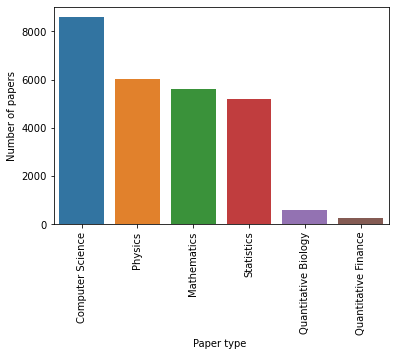

In [6]:
# no. of samples for each class
categories = train_df.columns.to_list()[3:]
plt.figure(figsize=(6, 4))

ax = sns.barplot(categories, train_df.iloc[:, 3:].sum().values)
plt.ylabel('Number of papers')
plt.xlabel('Paper type ')
plt.xticks(rotation=90)
plt.show()

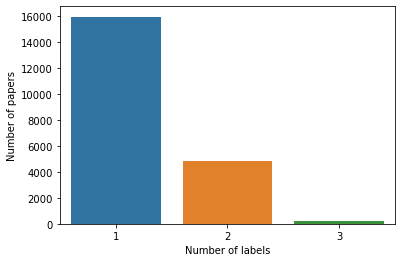

In [7]:
# no of samples having multiple labels
row_sums = train_df.iloc[:, 3:].sum(axis=1)
multilabel_counts = row_sums.value_counts()

plt.figure(figsize=(6, 4))
ax = sns.barplot(multilabel_counts.index, multilabel_counts.values)
plt.ylabel('Number of papers')
plt.xlabel('Number of labels')
plt.show()

<BarContainer object of 20972 artists>

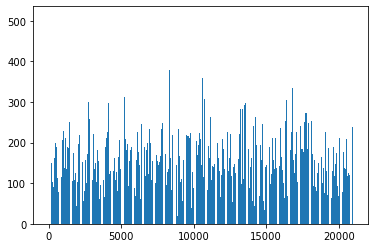

In [8]:
# text lengths
y = [len(t.split()) for t in texts]
x = range(0, len(y))
plt.bar(x, y)

<BarContainer object of 20972 artists>

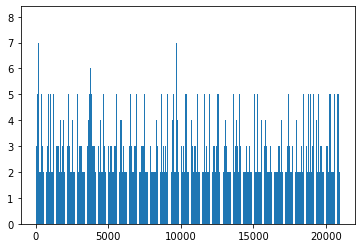

In [9]:
# label lengths
y = [len(l.split()) for l in labels]
x = range(0, len(y))
plt.bar(x, y)

From the plot above we can infer that, **320** seems like a good choice for **src MAX_LENGTH** and appx. **15** for **tgt MAX_LENGTH**.<br><br>
**Convention**
- src - texts<br>
- tgt - labels

# Config

Here we define a Config class, which contains all the fixed parameters & hyperparameters required for **Dataset** creation as well as **Model** training.

In [10]:
class Config:
    def __init__(self):
        super(Config, self).__init__()

        self.SEED = 42
        self.MODEL_PATH = 't5-base'

        # data
        self.TOKENIZER = T5Tokenizer.from_pretrained(self.MODEL_PATH)
        self.SRC_MAX_LENGTH = 320
        self.TGT_MAX_LENGTH = 20
        self.BATCH_SIZE = 16
        self.VALIDATION_SPLIT = 0.25

        # model
        self.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.FULL_FINETUNING = True
        self.LR = 3e-5
        self.OPTIMIZER = 'AdamW'
        self.CRITERION = 'BCEWithLogitsLoss'
        self.SAVE_BEST_ONLY = True
        self.N_VALIDATE_DUR_TRAIN = 3
        self.EPOCHS = 1

config = Config()

# Dataset & Dataloader

Now, we'll create a custom Dataset class inherited from the PyTorch Dataset class. We'll be using the **T5 tokenizer** that returns **input_ids** and **attention_mask**.<br><br>
The custom Dataset class will return a dict containing - <br>

- src_input_ids
- src_attention_mask
- tgt_input_ids'
-tgt_attention_mask

In [11]:
class T5Dataset(Dataset):
    def __init__(self, df, indices, set_type=None):
        super(T5Dataset, self).__init__()

        df = df.iloc[indices]
        self.texts = get_texts(df)
        self.set_type = set_type
        if self.set_type != 'test':
            self.labels = get_labels(df)

        self.tokenizer = config.TOKENIZER
        self.src_max_length = config.SRC_MAX_LENGTH
        self.tgt_max_length = config.TGT_MAX_LENGTH

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index):
        src_tokenized = self.tokenizer.encode_plus(
            self.texts[index], 
            max_length=self.src_max_length,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        src_input_ids = src_tokenized['input_ids'].squeeze()
        src_attention_mask = src_tokenized['attention_mask'].squeeze()

        if self.set_type != 'test':
            tgt_tokenized = self.tokenizer.encode_plus(
                self.labels[index], 
                max_length=self.tgt_max_length,
                pad_to_max_length=True,
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=False,
                return_tensors='pt'
            )
            tgt_input_ids = tgt_tokenized['input_ids'].squeeze()
            tgt_attention_mask = tgt_tokenized['attention_mask'].squeeze()

            return {
                'src_input_ids': src_input_ids.long(),
                'src_attention_mask': src_attention_mask.long(),
                'tgt_input_ids': tgt_input_ids.long(),
                'tgt_attention_mask': tgt_attention_mask.long()
            }

        return {
            'src_input_ids': src_input_ids.long(),
            'src_attention_mask': src_attention_mask.long()
        }

Our **T5Dataset** Class takes as input the **dataframe**, **indices** & **set_type**. We calculate the train / val set indices beforehand, pass it to **T5Dataset** and slice the dataframe using these indices.

In [12]:
# train-val split

np.random.seed(config.SEED)

dataset_size = len(train_df)
indices = list(range(dataset_size))
split = int(np.floor(config.VALIDATION_SPLIT * dataset_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

Here we'll initialize PyTorch DataLoader objects for the training & validation data.<br>
These dataloaders allow us to iterate over them during training, validation or testing and return a batch of the Dataset class outputs.

In [13]:
train_data = T5Dataset(train_df, train_indices)
val_data = T5Dataset(train_df, val_indices)

train_dataloader = DataLoader(train_data, batch_size=config.BATCH_SIZE)
val_dataloader = DataLoader(val_data, batch_size=config.BATCH_SIZE)

b = next(iter(train_dataloader))
for k, v in b.items():
    print(f'{k} shape: {v.shape}')

src_input_ids shape: torch.Size([16, 320])
src_attention_mask shape: torch.Size([16, 320])
tgt_input_ids shape: torch.Size([16, 20])
tgt_attention_mask shape: torch.Size([16, 20])


# Model

Coming to the most interesting part - the model architecture! We'll create a class named **Model**, inherited from **torch.nn.Module**.<br><br>

### Flow
- We initialize our pretrained T5 model with a Conditional Generation Head.
- Pass in the src & tgt, input_ids & attention_mask.
- The model returns the decoder generated output ids (predicted labels in textual format), which we need to decode further using the tokenizer.

In [14]:
class T5Model(nn.Module):
    def __init__(self):
        super(T5Model, self).__init__()

        self.t5_model = T5ForConditionalGeneration.from_pretrained(config.MODEL_PATH)

    def forward(
        self,
        input_ids, 
        attention_mask=None, 
        decoder_input_ids=None, 
        decoder_attention_mask=None, 
        lm_labels=None
        ):

        return self.t5_model(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            lm_labels=lm_labels,
        )

In [15]:
device = config.DEVICE
device

device(type='cuda')

# Engine

Our engine consists of the training and validation step functions.

In [16]:
# the get_ohe function converts the decoder generated labels from textual -
# - format to a one hot encoded form, in order to calculate the micro f1 score

def get_ohe(x):
    labels_li = ['_'.join(x.lower().split()) for x in train_df.columns.to_list()[3:]]
    labels_li_indices = dict()
    for idx, label in enumerate(labels_li):
        labels_li_indices[label] = idx
        
    y = [labels.split(', ') for labels in x]
    ohe = []
    for labels in y:
        temp = [0] * 6
        for label in labels:
            idx = labels_li_indices.get(label, -1)
            if idx != -1:
                temp[idx] = 1
        ohe.append(temp)
    ohe = np.array(ohe)
    return ohe

In [17]:
def val(model, val_dataloader, criterion):
    
    val_loss = 0
    true, pred = [], []
    
    # set model.eval() every time during evaluation
    model.eval()
    
    for step, batch in enumerate(val_dataloader):
        # unpack the batch contents and push them to the device (cuda or cpu).
        b_src_input_ids = batch['src_input_ids'].to(device)
        b_src_attention_mask = batch['src_attention_mask'].to(device)
    
        b_tgt_input_ids = batch['tgt_input_ids']
        lm_labels = b_tgt_input_ids.to(device)
        lm_labels[lm_labels[:, :] == config.TOKENIZER.pad_token_id] = -100

        b_tgt_attention_mask = batch['tgt_attention_mask'].to(device)

        # using torch.no_grad() during validation/inference is faster -
        # - since it does not update gradients.
        with torch.no_grad():
            # forward pass
            outputs = model(
                input_ids=b_src_input_ids, 
                attention_mask=b_src_attention_mask,
                lm_labels=lm_labels,
                decoder_attention_mask=b_tgt_attention_mask)
            loss = outputs[0]

            val_loss += loss.item()

            # get true 
            for true_id in b_tgt_input_ids:
                true_decoded = config.TOKENIZER.decode(true_id)
                true.append(true_decoded)

            # get pred (decoder generated textual label ids)
            pred_ids = model.t5_model.generate(
                input_ids=b_src_input_ids, 
                attention_mask=b_src_attention_mask
            )
            pred_ids = pred_ids.cpu().numpy()
            for pred_id in pred_ids:
                pred_decoded = config.TOKENIZER.decode(pred_id)
                pred.append(pred_decoded)

    true_ohe = get_ohe(true)
    pred_ohe = get_ohe(pred)

    avg_val_loss = val_loss / len(val_dataloader)
    print('Val loss:', avg_val_loss)
    print('Val accuracy:', accuracy_score(true_ohe, pred_ohe))

    val_micro_f1_score = f1_score(true_ohe, pred_ohe, average='micro')
    print('Val micro f1 score:', val_micro_f1_score)
    return val_micro_f1_score


def train(
    model,  
    train_dataloader, 
    val_dataloader, 
    criterion, 
    optimizer, 
    scheduler, 
    epoch
    ):
    
    # we validate config.N_VALIDATE_DUR_TRAIN times during the training loop
    nv = config.N_VALIDATE_DUR_TRAIN
    temp = len(train_dataloader) // nv
    temp = temp - (temp % 100)
    validate_at_steps = [temp * x for x in range(1, nv + 1)]
    
    train_loss = 0
    for step, batch in enumerate(tqdm(train_dataloader, 
                                      desc='Epoch ' + str(epoch))):
        # set model.eval() every time during training
        model.train()
        
        # unpack the batch contents and push them to the device (cuda or cpu).
        b_src_input_ids = batch['src_input_ids'].to(device)
        b_src_attention_mask = batch['src_attention_mask'].to(device)
    
        lm_labels = batch['tgt_input_ids'].to(device)
        lm_labels[lm_labels[:, :] == config.TOKENIZER.pad_token_id] = -100

        b_tgt_attention_mask = batch['tgt_attention_mask'].to(device)

        # clear accumulated gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(input_ids=b_src_input_ids, 
                        attention_mask=b_src_attention_mask,
                        lm_labels=lm_labels,
                        decoder_attention_mask=b_tgt_attention_mask)
        loss = outputs[0]
        train_loss += loss.item()

        # backward pass
        loss.backward()

        # update weights
        optimizer.step()
        
        # update scheduler
        scheduler.step()

        if step in validate_at_steps:
            print(f'-- Step: {step}')
            _ = val(model, val_dataloader, criterion)
    
    avg_train_loss = train_loss / len(train_dataloader)
    print('Training loss:', avg_train_loss)

# Run

### Loss function used<br>
- **BCEWithLogitsLoss** - Most commonly used loss function for Multi Label Classification tasks. Note that, PyTorch's BCEWithLogitsLoss is numerically stable than BCELoss.
<br>

### Optimizer used <br>
- **AdamW** - Commonly used optimizer. Performs better than Adam.
<br>

### Scheduler used <br>
- **get_linear_scheduler_with_warmup** from the **transformers** library.
<br>

In [18]:
def run():
    # setting a seed ensures reproducible results.
    # seed may affect the performance too.
    torch.manual_seed(config.SEED)

    criterion = nn.BCEWithLogitsLoss()
    
    # define the parameters to be optmized -
    # - and add regularization
    if config.FULL_FINETUNING:
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {
                "params": [
                    p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.001,
            },
            {
                "params": [
                    p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.0,
            },
        ]
        optimizer = optim.AdamW(optimizer_parameters, lr=config.LR)

    num_training_steps = len(train_dataloader) * config.EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )

    max_val_micro_f1_score = float('-inf')
    for epoch in range(config.EPOCHS):
        train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, epoch)
        val_micro_f1_score = val(model, val_dataloader, criterion)

        if config.SAVE_BEST_ONLY:
            if val_micro_f1_score > max_val_micro_f1_score:
                best_model = copy.deepcopy(model)
                best_val_micro_f1_score = val_micro_f1_score

                model_name = 't5_best_model'
                torch.save(best_model.state_dict(), model_name + '.pt')

                print(f'--- Best Model. Val loss: {max_val_micro_f1_score} -> {val_micro_f1_score}')
                max_val_micro_f1_score = val_micro_f1_score

    return best_model, best_val_micro_f1_score

In [19]:
model = T5Model()
model.to(device);

In [20]:
best_model, best_val_micro_f1_score = run()

-- Step: 300
Val loss: 0.42502599532102664
Val accuracy: 0.6225443448407401
Val micro f1 score: 0.6689551009199506
-- Step: 600
Val loss: 0.37236614341325147
Val accuracy: 0.6769025367156208
Val micro f1 score: 0.7422145328719723
-- Step: 900
Val loss: 0.3605981839639021
Val accuracy: 0.681098607667366
Val micro f1 score: 0.7358416872803021

Training loss: 0.6346240297898771
Val loss: 0.3590776126195745
Val accuracy: 0.6818615296585924
Val micro f1 score: 0.7381907596738708
--- Best Model. Val loss: -inf -> 0.7381907596738708


# Submission

Load the test dataset, and initialize a DataLoader object for it.

In [21]:
test_df = pd.read_csv(project_dir + 'test.csv')
dataset_size = len(test_df)
test_indices = list(range(dataset_size))

test_data = T5Dataset(test_df, test_indices, set_type='test')
test_dataloader = DataLoader(test_data, batch_size=config.BATCH_SIZE)

In [22]:
def predict(model):
    val_loss = 0
    pred = []
    model.eval()
    for step, batch in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        b_src_input_ids = batch['src_input_ids'].to(device)
        b_src_attention_mask = batch['src_attention_mask'].to(device)

        with torch.no_grad():
            # get pred
            pred_ids = model.t5_model.generate(
                input_ids=b_src_input_ids, 
                attention_mask=b_src_attention_mask
            )
            pred_ids = pred_ids.cpu().numpy()
            for pred_id in pred_ids:
                pred_decoded = config.TOKENIZER.decode(pred_id)
                pred.append(pred_decoded)

    pred_ohe = get_ohe(pred)
    return pred_ohe

pred_ohe = predict(best_model)

In [23]:
sample_submission = pd.read_csv('sample_submission.csv')
ids = sample_submission['ID'].values.reshape(-1, 1)

merged = np.concatenate((ids, pred_ohe), axis=1)
submission = pd.DataFrame(merged, columns=sample_submission.columns).astype(int)

submission

FileNotFoundError: [Errno 2] No such file or directory: 'sample_submission.csv'

In [24]:
submission_fname = f't5_microf1-{round(best_val_micro_f1_score, 4)}.csv'
submission.to_csv(submissions_dir + submission_fname, index=False)

NameError: name 'submission' is not defined